In [3]:
#环境
import scipy
from scipy import misc
import imageio
from scipy import ndimage
import numpy as np
import matplotlib.pyplot as plt

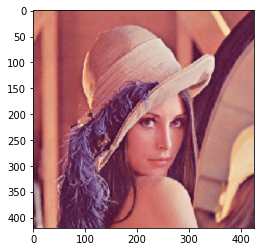

In [4]:


#导入图像
lion = imageio.imread('/Users/leslie/Desktop/革命成果-学术/LENA.jpg') 
plt.imshow(lion, cmap = plt.get_cmap('gray'))
plt.show()

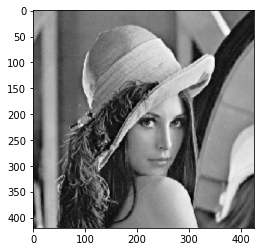

In [5]:
#变成灰度图
lion_gray = np.dot(lion[...,:3], [0.299, 0.587, 0.114])
#lion_gray = lion_gray.astype('int32')
plt.imshow(lion_gray, cmap = plt.get_cmap('gray'))
plt.show()

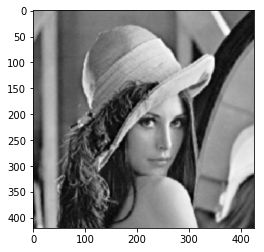

In [6]:
#高斯模糊，降噪
lion_gray_blurred = ndimage.gaussian_filter(lion_gray, sigma=1.0) # sigma值根据图像变化
plt.imshow(lion_gray_blurred, cmap = plt.get_cmap('gray'))
plt.show()

In [7]:
#同sobel算子，计算梯度
#sobel算子也可以是其他矩阵，这里选择最大梯度是2的矩阵
def SobelFilter(img, direction):
    if(direction == 'x'):
        Gx = np.array([[-1,0,+1], [-2,0,+2],  [-1,0,+1]])
        Res = ndimage.convolve(img, Gx)
    
    if(direction == 'y'):
        Gy = np.array([[-1,-2,-1], [0,0,0], [+1,+2,+1]])
        Res = ndimage.convolve(img, Gy)
    
    
    return Res

In [8]:
# 正则化步骤，正则化后像素<=1
def Normalize(img):
   # img = np.multiply(img, 255 / np.max(img))
    img = img/np.max(img)
    return img


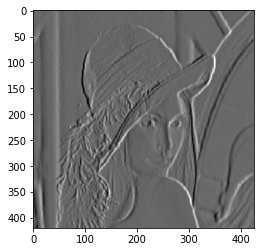

In [9]:
#X轴应用Sobel算子
gx = SobelFilter(lion_gray_blurred, 'x')
gx = Normalize(gx)
plt.imshow(gx, cmap = plt.get_cmap('gray'))
plt.show()

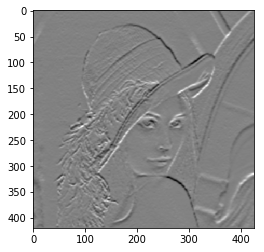

In [10]:
#Y轴应用Sobel算子
gy = SobelFilter(lion_gray_blurred, 'y')
gy = Normalize(gy)
plt.imshow(gy, cmap = plt.get_cmap('gray'))
plt.show()

In [11]:
# 应用SCIPY自带的函数实现Sobel算子，进行验证
#dx = ndimage.sobel(lion_gray_blurred, axis=1, mode='constant', cval=0.0)  # horizontal derivative
#dy = ndimage.sobel(lion_gray_blurred, axis=0, mode='constant', cval=0.0)  # vertical derivative

dx = ndimage.sobel(lion_gray_blurred, axis=1) # horizontal derivative
dy = ndimage.sobel(lion_gray_blurred, axis=0) # vertical derivative

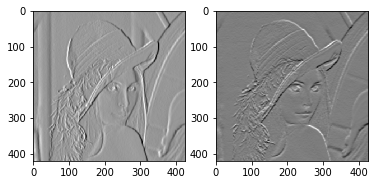

In [12]:
# 应用SCIPY自带的函数实现Sobel算子，进行验证
plt.subplot(121)
plt.imshow(dx, cmap = plt.get_cmap('gray'))
plt.subplot(122)
plt.imshow(dy, cmap = plt.get_cmap('gray'))
plt.show()

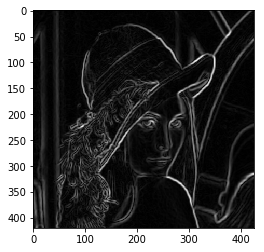

In [13]:
#计算获得的梯度的大小
Mag = np.hypot(gx,gy)
Mag = Normalize(Mag)#归一化 使得没有可比性的数据变得具有可比性，同时又保持相比较的两个数据之间的相对关系 在这里使像素大小都<=1
plt.imshow(Mag, cmap = plt.get_cmap('gray'))
plt.show()

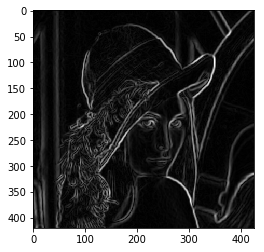

In [14]:
#build in 函数验证
mag = np.hypot(dx,dy)
mag = Normalize(mag)
plt.imshow(mag, cmap = plt.get_cmap('gray'))
plt.show()

In [15]:
# 计算梯度方向
Gradient = np.degrees(np.arctan2(gy,gx))

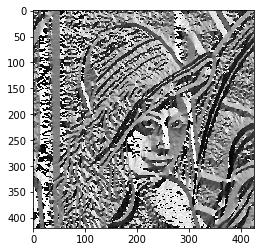

In [16]:
# Build in 函数计算函数方向用于验证
plt.imshow(Gradient,cmap=plt.get_cmap('gray'))
plt.show()
gradient = np.degrees(np.arctan2(dy,dx))

In [15]:
#得到边界
def NonMaxSupWithInterpol(Gmag, Grad, Gx, Gy):
    NMS = np.zeros(Gmag.shape)
    
    for i in range(1, int(Gmag.shape[0]) - 1):
        for j in range(1, int(Gmag.shape[1]) - 1):
            if((Grad[i,j] >= 0 and Grad[i,j] <= 45) or (Grad[i,j] < -135 and Grad[i,j] >= -180)):
                yBot = np.array([Gmag[i,j+1], Gmag[i+1,j+1]])
                yTop = np.array([Gmag[i,j-1], Gmag[i-1,j-1]])
                x_est = np.absolute(Gy[i,j]/Gmag[i,j])
                if (Gmag[i,j] >= ((yBot[1]-yBot[0])*x_est+yBot[0]) and Gmag[i,j] >= ((yTop[1]-yTop[0])*x_est+yTop[0])):
                    NMS[i,j] = Gmag[i,j]
                else:
                    NMS[i,j] = 0
            if((Grad[i,j] > 45 and Grad[i,j] <= 90) or (Grad[i,j] < -90 and Grad[i,j] >= -135)):
                yBot = np.array([Gmag[i+1,j] ,Gmag[i+1,j+1]])
                yTop = np.array([Gmag[i-1,j] ,Gmag[i-1,j-1]])
                x_est = np.absolute(Gx[i,j]/Gmag[i,j])
                if (Gmag[i,j] >= ((yBot[1]-yBot[0])*x_est+yBot[0]) and Gmag[i,j] >= ((yTop[1]-yTop[0])*x_est+yTop[0])):
                    NMS[i,j] = Gmag[i,j]
                else:
                    NMS[i,j] = 0
            if((Grad[i,j] > 90 and Grad[i,j] <= 135) or (Grad[i,j] < -45 and Grad[i,j] >= -90)):
                yBot = np.array([Gmag[i+1,j] ,Gmag[i+1,j-1]])
                yTop = np.array([Gmag[i-1,j] ,Gmag[i-1,j+1]])
                x_est = np.absolute(Gx[i,j]/Gmag[i,j])
                if (Gmag[i,j] >= ((yBot[1]-yBot[0])*x_est+yBot[0]) and Gmag[i,j] >= ((yTop[1]-yTop[0])*x_est+yTop[0])):
                    NMS[i,j] = Gmag[i,j]
                else:
                    NMS[i,j] = 0
            if((Grad[i,j] > 135 and Grad[i,j] <= 180) or (Grad[i,j] < 0 and Grad[i,j] >= -45)):
                yBot = np.array([Gmag[i,j-1] ,Gmag[i+1,j-1]])
                yTop = np.array([Gmag[i,j+1] ,Gmag[i-1,j+1]])
                x_est = np.absolute(Gy[i,j]/Gmag[i,j])
                if (Gmag[i,j] >= ((yBot[1]-yBot[0])*x_est+yBot[0]) and Gmag[i,j] >= ((yTop[1]-yTop[0])*x_est+yTop[0])):
                    NMS[i,j] = Gmag[i,j]
                else:
                    NMS[i,j] = 0
    
    return NMS
                
            

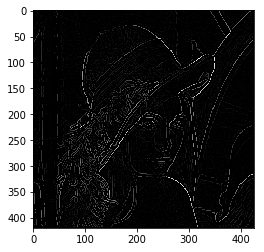

In [16]:
# 获取非最大抑制输出
NMS = NonMaxSupWithInterpol(Mag, Gradient, gx, gy)
NMS = Normalize(NMS)
plt.imshow(NMS, cmap = plt.get_cmap('gray'))
plt.show()

In [17]:
#双阈值
#连接图像1和2
def DoThreshHyst(img):
    highThresholdRatio = 0.2  
    lowThresholdRatio = 0.15 
    GSup = np.copy(img)
    h = int(GSup.shape[0])
    w = int(GSup.shape[1])
    highThreshold = np.max(GSup) * highThresholdRatio
    lowThreshold = highThreshold * lowThresholdRatio    
    x = 0.1
    oldx=0
    
#使用while循环使循环继续执行，直到强边的数量不变，即连接到强边的所有弱边都被找到。
    while(oldx != x):
        oldx = x
        for i in range(1,h-1):
            for j in range(1,w-1):
                if(GSup[i,j] > highThreshold):
                    GSup[i,j] = 1
                elif(GSup[i,j] < lowThreshold):
                    GSup[i,j] = 0
                else:
                    if((GSup[i-1,j-1] > highThreshold) or 
                        (GSup[i-1,j] > highThreshold) or
                        (GSup[i-1,j+1] > highThreshold) or
                        (GSup[i,j-1] > highThreshold) or
                        (GSup[i,j+1] > highThreshold) or
                        (GSup[i+1,j-1] > highThreshold) or
                        (GSup[i+1,j] > highThreshold) or
                        (GSup[i+1,j+1] > highThreshold)):
                        GSup[i,j] = 1
        x = np.sum(GSup == 1)
    
    GSup = (GSup == 1) * GSup # 把在更不严格（图1）阈值图中的，并且没有连接到严格（图2）阈值的图中的边删除，即只保留连接到强边的弱边。
    
    return GSup
                

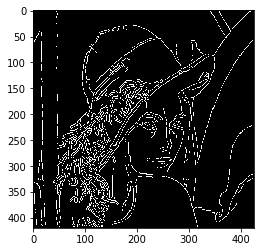

In [18]:
#Canny 边缘检测的输出
Final_Image = DoThreshHyst(NMS)
plt.imshow(Final_Image, cmap = plt.get_cmap('gray'))
plt.show()